In [ ]:
from pathlib import Path
import matplotlib.style
import matplotlib as mpl
import torch

DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)
mpl.style.use("default")

checkpoint = torch.load('./model.pt')


In [ ]:
from maldi2resistance.data.ArtificalMixed import ArtificialMixedInfection
from maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    bin_size=1
    # antibiotics= ['Ciprofloxacin', 'Ceftriaxone', "Cefepime", "Piperacillin-Tazobactam", "Tobramycin"]
)

driams.loading_type = "memory"

gen = torch.Generator()

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator=gen.manual_seed(SEED))

test_dataset_mixed = ArtificialMixedInfection(test_dataset, generator_seed=SEED, use_percent_of_data=1)

test = torch.utils.data.ConcatDataset([test_dataset, test_dataset_mixed])



/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2015) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2016) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-B) and Year (2017) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-C) and Year (2015) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-C) and Year (2016) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data/driams.py:86: UserWarning: Metafile for Site (DRIAMS-C) and Year (2017) combination not found!
  warnings.warn(
/home/jan/Uni/master/src/maldi2resistance/data

Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

  0%|          | 0/5578 [00:00<?, ?it/s]

In [ ]:
len(test_dataset)

11156

In [ ]:
len(test_dataset_mixed)

5578

In [ ]:
len(test)

16734

In [ ]:
driams.label_stats

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,...,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
positive,1068,13366,8578,21966,628,618,4223,7383,2338,3470,...,1205,5537,12431,7616,486,580,244,3534,1707,227
negative,20941,24992,4194,4905,456,457,5813,31567,4382,24566,...,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
n_sum,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,...,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test, batch_size=len(test), shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim=len(driams.selected_antibiotics))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=38, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
model = model.to(DEVICE)
model.eval()

test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

(0.9208430051803589, 0.8965169646238026)


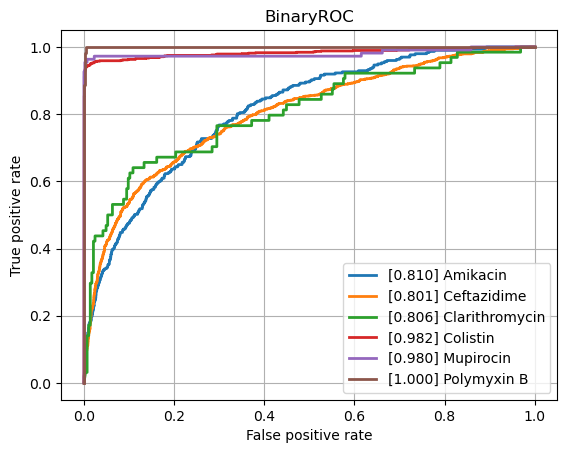

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results_mixed.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results_mixed.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.8604819774627686, 0.7646845430135727)


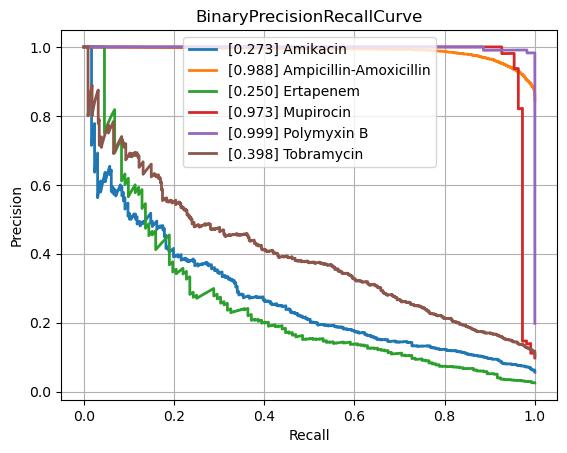

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results_mixed.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results_mixed.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
import gc

del test_features, test_labels, output

torch.cuda.empty_cache()
gc.collect()

torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

(0.9272277355194092, 0.9014867748084822)


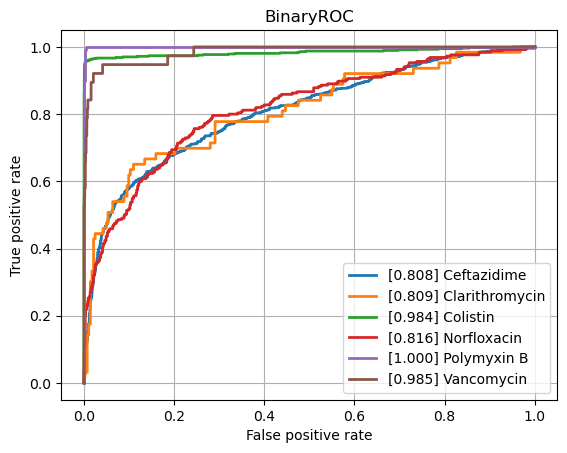

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.8629206418991089, 0.7712278271976271)


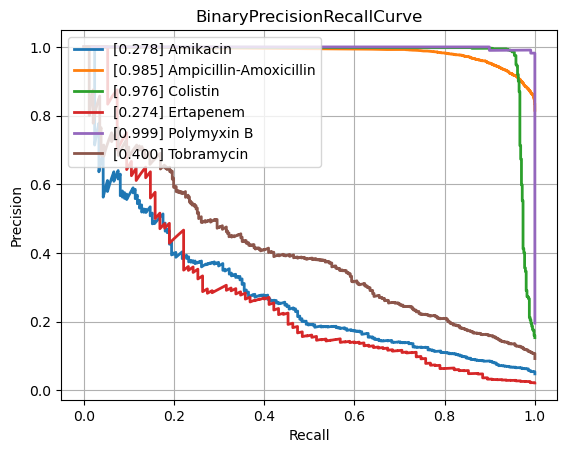

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
import gc

del test_features, test_labels, output

torch.cuda.empty_cache()
gc.collect()

torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset_mixed, batch_size=len(test_dataset_mixed), shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
test_features = test_features.to(DEVICE)
test_labels = test_labels.to(DEVICE)

In [ ]:
output = model(test_features)

/home/jan/anaconda3/envs/master_backend/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


(0.8805921077728271, 0.7786032228093398)


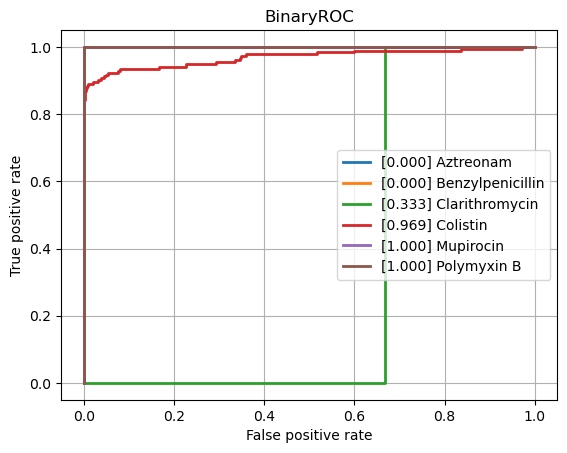

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results_only_mixed.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results_only_mixed.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.852459192276001, 0.7375028380437901)


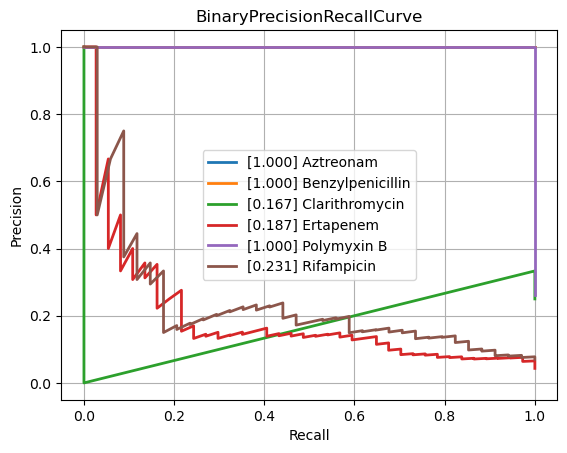

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results_only_mixed.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results_only_mixed.png", transparent=True, format= "png", bbox_inches = "tight")
plt.show()